In [61]:
#!/usr/bin/env python
# coding=utf-8

# Evaluates channel popularity statistics based on collaboration data
# Channel subscriber and view count gradient and % growth plots

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math


from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import seaborn as sns
sns.set(color_codes=True)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    #fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [62]:
DIR = '../../data/data_evaluation_2'
CDIR = '../../data/data_evaluation_2/charts'

db = YTDatabase()

In [3]:
df_channel = pa.read_csv(DIR+r'/df_channel_statistics_first_day.txt', sep=str('\t'), encoding='utf-8')

In [4]:
df_graph = pa.read_csv(DIR+r'/df_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)
df_graph_filtered = pa.read_csv(DIR+r'/df_filtered_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)


df_graph_filtered['from_cluster'] = df_graph_filtered['from_cluster'].apply(json.loads)
df_graph_filtered['to_cluster'] = df_graph_filtered['to_cluster'].apply(json.loads)
df_graph_filtered['videos'] = df_graph_filtered['videos'].apply(json.loads)

print len(df_graph)
print len(df_graph_filtered)


df_graph_filtered.head()

1269
1214


,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
0,3521,UCZApDB9BW7ZjNcPb3Wu7rRg,Entertainment,"[2018, 2707, 3204, 3205, 3521]",None,3,Food,UC5evWLowv059QIovMFlKKBA,Music,,1l1lv2tvbn7LsHWoygrwgA,3,Music,[Y4x2dAXup3U],1
1,3521,UCZApDB9BW7ZjNcPb3Wu7rRg,Entertainment,"[2018, 2707, 3204, 3205, 3521]",None,3,Food,UC4WjlJxCPSbykB0P3R1My1Q,Sports,"[101, 387, 2368, 2957, 3128, 3129, 3751]",None,2,Sports,"[FFMLvYw9CK4, HWGFUWANtvQ]",2
2,3678,UCGrs4qEyhPEavGBHNdDi26A,Entertainment,[3678],BroadbandTV,3,Action game,UC7IJcslj7NPvo12tyO5Qguw,People & Blogs,[],BroadbandTV,3,Movies,"[1pUSd8MInd4, M668-FpmXgc, fQK9Sx6rk-c, i5bPuA...",5
3,2626,UC9Q0dAjbhv0FbwvoHRSmjxA,How-to & Style,"[1478, 2626, 2649]",Maker Studios,4,Hobby,UCY26xU0-avwTJ6F6TzUZVEw,Film & Animation,"[877, 1001, 1047, 2483, 2816]",DreamWorksTV,4,Movies,[DdUV2Yh53Ws],1
4,3674,UCLFTOcssnu2LGS3FxGA5tsQ,Entertainment,"[3674, 3695]",None,3,Hobby,UC7Rrbm84x8RK0OkKlHpmiUQ,Entertainment,"[3540, 3689, 3773]",BroadbandTV,4,Hobby,"[dB50g5a1Dx8, vl5VxPhX2LA]",2


In [5]:
# get history statistscs from db of videos and channel

with db._session_scope(False) as session:

    df_channel_history = pa.read_sql(session.query(ChannelHistory).statement, db.engine)
    df_channel_history_collabs = pa.read_sql(session.query(ChannelHistory).filter((ChannelHistory.channelID.in_(df_graph_filtered['from'].tolist())) | (ChannelHistory.channelID.in_(df_graph_filtered['to'].tolist()))).statement, db.engine)

In [7]:
df_channel_history = df_channel_history.set_index(['id'])
df_channel_history_collabs = df_channel_history_collabs.set_index(['id'])

df_channel_history['crawlTimestamp'] = df_channel_history['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))
df_channel_history_collabs['crawlTimestamp'] = df_channel_history_collabs['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))

df_unfixed_channel_history_collabs = df_channel_history_collabs.copy()

df_channel_history.head()
#df_channel_history_collabs.head()

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp
id,,,,,,
1,UC--BMyA2X4a9PGAo3lTuopg,123961982,878515,3825,41,2016-12-28 02:57:13
2,UC-27_Szq7BtHDoC0R2U0zxA,1495970510,7783038,9610,401,2016-12-28 02:57:13
3,UC--v6kgEGoApDbKVwFR44cA,4531047,46739,3,229,2016-12-28 02:57:13
4,UC-63s9JLCZqIDlhXK6VHb7w,8834171,27606,0,89,2016-12-28 02:57:14
5,UC-4kjzuh4822B9yPSgpZQgA,28671226,1234411,0,49,2016-12-28 02:57:14


In [8]:
# channel history grouping
channel_groups = df_channel_history.groupby(['channelID'])

print 'Number of channel complete:',len(channel_groups)
print 'Number of data points for all channel:', len(df_channel_history)
#channel_groups.head()

Number of channel complete: 7942
Number of data points for all channel: 507413


In [9]:
# only channel which did a collab
# we concentrate on this dataset mainly (because data of channels with no collab would be mixed in)
channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])
unfixed_channel_collabs_groups = df_unfixed_channel_history_collabs.groupby(['channelID'])

print 'Number of channel with collabs:',len(channel_collabs_groups)
print 'Number of data points for channel with collabs:', len(df_channel_history_collabs)
#channel_collabs_groups.head()

Number of channel with collabs: 1059
Number of data points for channel with collabs: 67776


<IPython.core.display.Javascript object>


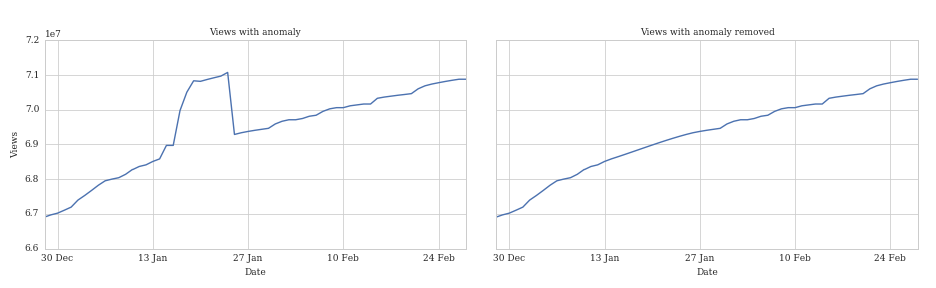

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


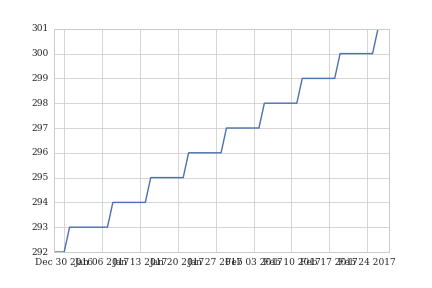

In [10]:
# sample removal of bug in channel viewcounts
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

bug_group = channel_collabs_groups.get_group('UCavTVjugW1OejDAq0aDzdMw')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,4), sharey=True)
fmt = DateFormatter("%d %b")

ax1.plot_date(bug_group['crawlTimestamp'], bug_group['viewCount'], 'b-')
ax1.set_xlabel('Date')
ax2.set_xlabel('Date')
ax1.set_ylabel('Views')

ax1.set_title('Views with anomaly')
ax2.set_title('Views with anomaly removed')

plt.legend()
ax1.xaxis.set_major_formatter(fmt)

# fixing
bug_value = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 24), 'viewCount'].item() - bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 25), 'viewCount'].item()

bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] - bug_value

bug_group.ix[(bug_group.crawlTimestamp > "2017-01-15") & (bug_group.crawlTimestamp < "2017-01-19"), 'viewCount'] = np.nan
bug_group.ix[(bug_group.crawlTimestamp > "2017-01-19") & (bug_group.crawlTimestamp < "2017-01-25"), 'viewCount'] = np.nan

bug_group.ix[:,'viewCount'] = bug_group['viewCount'].interpolate(method='cubic')

ax2.plot_date(bug_group['crawlTimestamp'], bug_group['viewCount'], 'b-')
ax1.set_xticks(ax1.get_xticks()[::2])
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.xaxis.set_major_formatter(fmt)
#ax2.tick_params(axis='x', pad=15)
plt.subplots_adjust(left=0.6, bottom=None, right=None, top=None, wspace=None, hspace=None)
#plt.suptitle('Sample Video Views')
plt.tight_layout()
fig.subplots_adjust(top=0.86)
#save_plot('channel_viewcount_anomaly_sample.pdf', fig, 2*s_width, s_height)


fig, axs = plt.subplots()
axs.plot_date(bug_group['crawlTimestamp'], bug_group['videoCount'], 'b-')

In [11]:
# remove viewcount anomaly so it can be used for boxplots etc.
# collab channel list

for name, bug_group in channel_collabs_groups:

    # fixing
    bug_value = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 24), 'viewCount'].item() - bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 25), 'viewCount'].item()

    bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] - bug_value

    bug_group.ix[(bug_group.crawlTimestamp > "2017-01-15") & (bug_group.crawlTimestamp < "2017-01-19"), 'viewCount'] = np.nan
    bug_group.ix[(bug_group.crawlTimestamp > "2017-01-19") & (bug_group.crawlTimestamp < "2017-01-25"), 'viewCount'] = np.nan

    bug_group.ix[:,'viewCount'] = bug_group['viewCount'].interpolate(method='cubic')

    df_channel_history_collabs.ix[bug_group.index, 'viewCount'] = bug_group['viewCount']

<IPython.core.display.Javascript object>


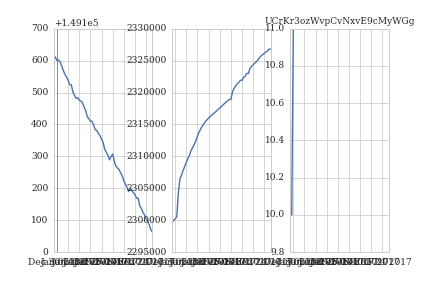

[u'IBO1zJNFd1c']
IBO1zJNFd1c
2016-12-29T18:52:31.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


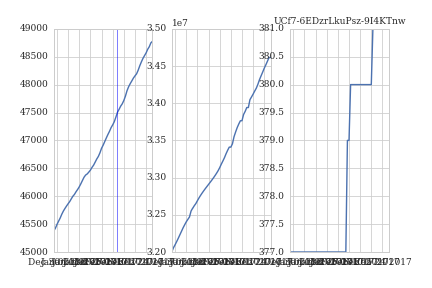

[u'cdiRdTXRNBs']
cdiRdTXRNBs
2017-02-05T17:58:36.000Z 1 ( 2 )


<IPython.core.display.Javascript object>


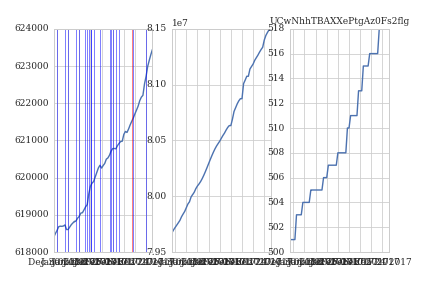

[u'XgQTU374jvM']
XgQTU374jvM
2017-02-15T06:22:00.000Z 3 ( 3 )
[u'-fuK77M-SJI', u'1ekUXRpMnnA', u'6Z4DQKPeKnY', u'JIaXrx6qeAw', u'NXx1i8ZxUNU', u'desbSD3gY4w', u'eugvmX6YKZw', u'kCKKzigrj74']
-fuK77M-SJI
2017-02-03T03:33:27.000Z 3 ( 3 )
1ekUXRpMnnA
2017-01-20T05:32:18.000Z 3 ( 3 )
6Z4DQKPeKnY
2016-12-30T02:06:13.000Z 3 ( 3 )
JIaXrx6qeAw
2017-01-03T23:30:33.000Z 3 ( 3 )
NXx1i8ZxUNU
2017-01-11T02:14:23.000Z 3 ( 3 )
desbSD3gY4w
2017-02-01T02:25:39.000Z 3 ( 3 )
eugvmX6YKZw
2017-01-16T20:51:46.000Z 3 ( 3 )
kCKKzigrj74
2017-01-13T00:49:09.000Z 3 ( 3 )
[u'8e1FfnuAMAw', u'JP5sAkiOoU4', u'OYQanooFYP0', u'SLPthbZyXcg', u'VtB2TZ6794E', u'b0u8GT7wbjU', u'd1YZWg29o1g', u'fltGqqfMuX8', u'hROIONMk9lg', u'j1JBI46cZsE']
8e1FfnuAMAw
2017-02-15T21:20:47.000Z 3 ( 3 )
JP5sAkiOoU4
2017-02-05T03:34:24.000Z 3 ( 3 )
OYQanooFYP0
2017-01-05T22:19:54.000Z 3 ( 3 )
SLPthbZyXcg
2017-01-20T03:17:30.000Z 3 ( 3 )
VtB2TZ6794E
2017-01-22T01:30:27.000Z 3 ( 3 )
b0u8GT7wbjU
2017-01-17T20:03:51.000Z 3 ( 3 )
d1YZWg29o1g
2017-0

<IPython.core.display.Javascript object>


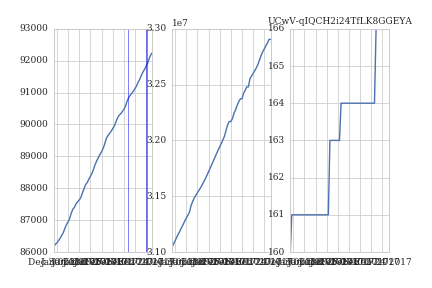

[u'sOmsfbPTw8w']
sOmsfbPTw8w
2017-02-12T17:00:04.000Z 3 ( 2 )
[u'Uc_go4JUsfM', u'ppLertBEeV8']
Uc_go4JUsfM
2017-02-24T18:00:05.000Z 4 ( 2 )
ppLertBEeV8
2017-02-23T18:00:05.000Z 4 ( 2 )


<IPython.core.display.Javascript object>


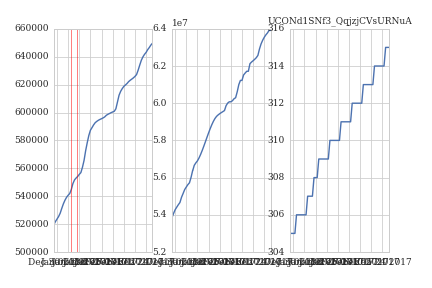

[u'4V2qKEwH4NM', u'yzyPnIPcf64']
4V2qKEwH4NM
2017-01-11T13:08:16.000Z 3 ( 3 )
yzyPnIPcf64
2017-01-07T13:00:24.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


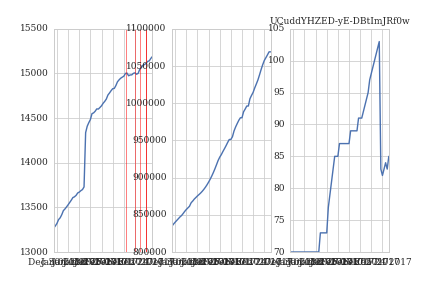

[u'8PDlAqyH0nE']
8PDlAqyH0nE
2017-02-24T03:42:02.000Z 2 ( 2 )
[u'8RLoNRplTxw']
8RLoNRplTxw
2017-02-17T03:29:27.000Z 6 ( 2 )
[u'4aiwgIF2i7s']
4aiwgIF2i7s
2017-02-20T03:05:57.000Z 3 ( 2 )
[u'8PDlAqyH0nE']
8PDlAqyH0nE
2017-02-24T03:42:02.000Z 3 ( 2 )
[u's5O_EE_ew-E']
s5O_EE_ew-E
2017-02-11T07:11:54.000Z 1 ( 2 )


<IPython.core.display.Javascript object>


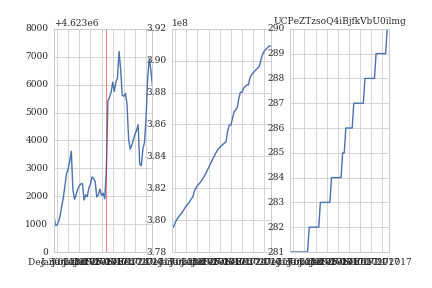

[u'xN9AP6ql5RM']
xN9AP6ql5RM
2017-01-29T18:00:22.000Z 4 ( 4 )


<IPython.core.display.Javascript object>


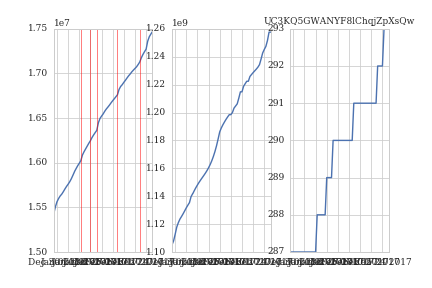

[u'3_GqRk_bTLo', u'BeaneyVdzoc', u'IaMawm2BWPc', u'ObNpudJcbV0', u'RaLVva73aq0']
3_GqRk_bTLo
2017-02-05T23:00:00.000Z 3 ( 5 )
BeaneyVdzoc
2017-01-13T23:00:00.000Z 3 ( 5 )
IaMawm2BWPc
2017-01-23T23:00:00.000Z 3 ( 5 )
ObNpudJcbV0
2017-02-20T00:30:01.000Z 3 ( 5 )
RaLVva73aq0
2017-01-19T23:00:01.000Z 3 ( 5 )


<IPython.core.display.Javascript object>


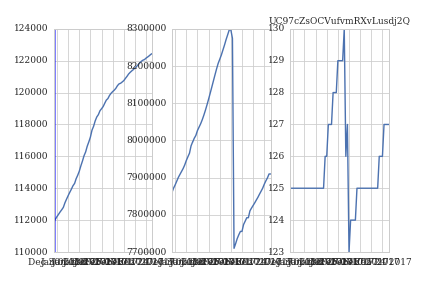

[u'e-U6Su57DPU']
e-U6Su57DPU
2016-12-29T01:12:44.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


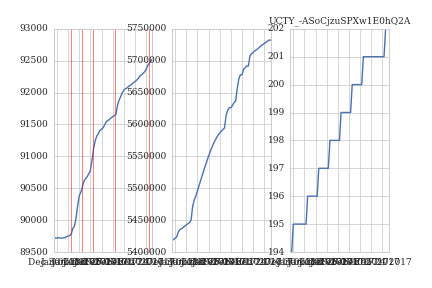

[u'M8U0hkgZejU', u'OzeYibphCD4', u'QgXCXxMhV1s', u'TFribXd6_bQ', u'hqJMTcRLBYc']
M8U0hkgZejU
2017-02-04T12:30:00.000Z 3 ( 2 )
OzeYibphCD4
2017-02-25T12:30:00.000Z 3 ( 2 )
QgXCXxMhV1s
2017-01-21T12:30:01.000Z 3 ( 2 )
TFribXd6_bQ
2017-01-07T12:30:01.000Z 3 ( 2 )
hqJMTcRLBYc
2017-01-14T12:30:00.000Z 3 ( 2 )


In [12]:
# print viewcounts for test
# sample channel statistics
import random


sampled_df_i  = random.sample(channel_collabs_groups.indices, 10)
df_list  = map(lambda df_i: (df_i, channel_collabs_groups.get_group(df_i)), sampled_df_i)

for name, group in df_list:
    #print name
    fig, axs = plt.subplots(ncols=3, )
    plt.title(name)
    axs[0].plot_date(group['crawlTimestamp'], group['subscriberCount'], 'b-')
    axs[1].plot_date(group['crawlTimestamp'], group['viewCount'], 'b-')
    axs[2].plot_date(group['crawlTimestamp'], group['videoCount'], 'b-')
    
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            print row.videos
            for vid in row['videos']:
                print vid
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['from_popularity']), '(',row['to_popularity'], ')'
                axs[0].axvline(x=date, color='red', linewidth=.5)

        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            print row.videos
            for vid in row['videos']:
                print vid
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['to_popularity']), '(',row['from_popularity'], ')'
                axs[0].axvline(x=date, color='blue', linewidth=.5)


<IPython.core.display.Javascript object>


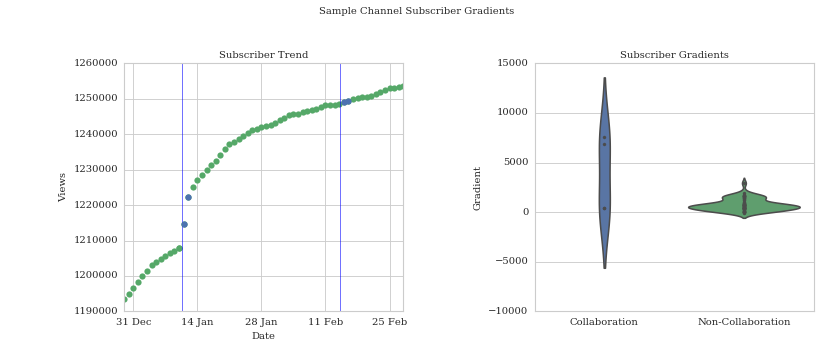

UCavTVjugW1OejDAq0aDzdMw
2017-01-10T17:09:15.000Z 6 ( 4 )
2017-02-14T05:12:46.000Z 3 ( 4 )


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [69]:
# KickthePJ channel subscriberCount plot, boxplot test

name = 'UCavTVjugW1OejDAq0aDzdMw'
group = channel_collabs_groups.get_group(name)

videos = []
fig, (ax1, ax2) = plt.subplots(ncols=2)
plt.title(name)
print name
ax1.plot_date(group['crawlTimestamp'], group['subscriberCount'], 'go', label='Subscriber')
label=True
with db._session_scope(False) as session:
    # own videos
    for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
            print date, str(row['from_popularity']), '(',row['to_popularity'], ')'
            ax1.axvline(x=date, color='blue', linewidth=.5, label="Collaboration" if label else "")
            label = False
            videos.append( (vid, date) )


    # external videos (hes in)
    for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
            print date, str(row['to_popularity']), '(',row['from_popularity'], ')'
            ax1.axvline(x=date, color='blue', linewidth=.5, label="Collaboration" if label else "")
            label = False
            videos.append( (vid, date) )


            
df_group_videos = pa.DataFrame(videos, columns=['video', 'date'])

subs = group['subscriberCount'].values
group.drop(group.index[:1], inplace=True)

group['gradient'] = np.diff(subs)
group['collab_window'] = 'Non_Collab'

df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))

label=True
for index, row in df_group_videos.iterrows():
    date, date_plus = row['date'], row['date_plus']
    filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
    group.ix[filtered.index, 'collab_window'] = 'Collab'
             
    ax1.plot(filtered['crawlTimestamp'], filtered['subscriberCount'], 'bo', label="Collaboration Window" if label else "")
    label = False
    #ax1.axvline(x=date, color='green', linewidth=.5)
    #ax1.axvline(x=date_plus, color='green', linewidth=.5)
    
sns.violinplot(x="collab_window", y="gradient", data=group, ax=ax2, order=['Collab', 'Non_Collab'], inner='point')

ax1.set_xlabel('Date')
ax1.set_ylabel('Views')
fmt = DateFormatter("%d %b")
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.xaxis.set_major_formatter(fmt)
ax1.legend(bbox_to_anchor=(0.6, -0.6), loc=3)

ax1.set_title('Subscriber Trend')
ax2.set_title('Subscriber Gradients')
ax2.set_ylabel('Gradient')
ax2.set_xlabel('')
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
plt.suptitle('Sample Channel Subscriber Gradients')
fig.tight_layout()
fig.subplots_adjust(top=0.82)

save_plot('channel_subscriber_gradient_sample_violin.pdf', fig, 2*s_width, s_height)


<IPython.core.display.Javascript object>


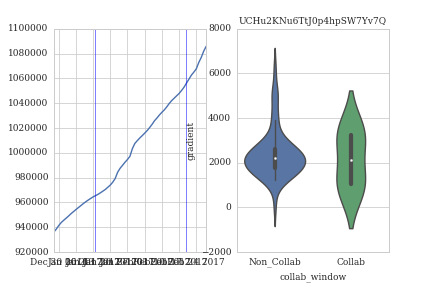

UCHu2KNu6TtJ0p4hpSW7Yv7Q
2017-02-19T15:10:22.000Z 2 ( 3 )
2017-01-13T21:32:58.000Z 3 ( 3 )


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

<IPython.core.display.Javascript object>


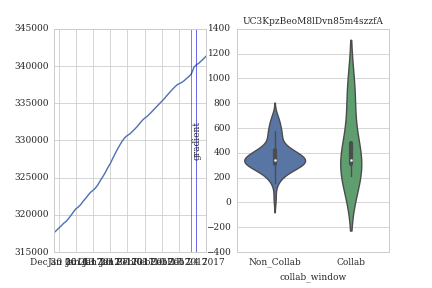

UC3KpzBeoM8lDvn85m4szzfA
2017-02-21T21:00:00.000Z 2 ( 3 )
2017-02-23T18:06:11.000Z 1 ( 3 )


<IPython.core.display.Javascript object>


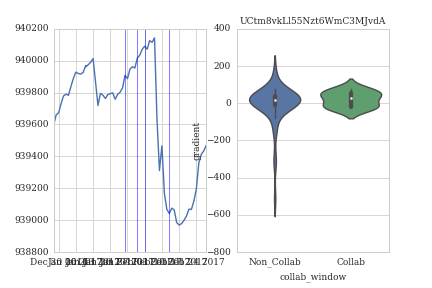

UCtm8vkLl55Nzt6WmC3MJvdA
2017-01-25T19:07:04.000Z 3 ( 3 )
2017-01-30T17:18:32.000Z 3 ( 3 )
2017-02-12T17:07:18.000Z 3 ( 3 )
2017-02-03T03:14:17.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


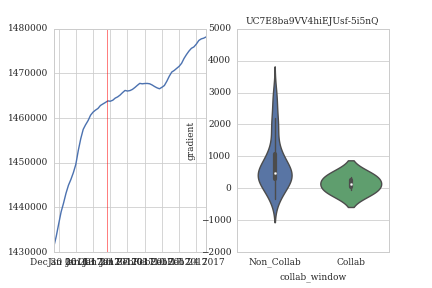

UC7E8ba9VV4hiEJUsf-5i5nQ
2017-01-18T19:16:13.000Z 4 ( 4 )


<IPython.core.display.Javascript object>


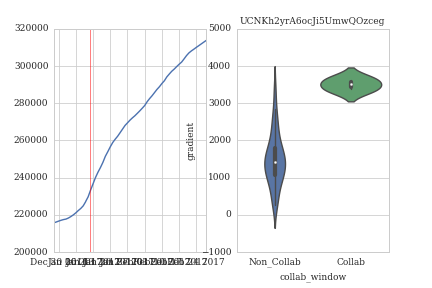

UCNKh2yrA6ocJi5UmwQOzceg
2017-01-11T15:02:09.000Z 2 ( 3 )


<IPython.core.display.Javascript object>


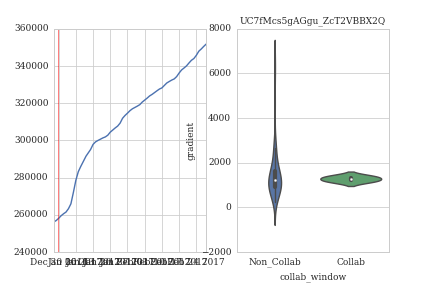

UC7fMcs5gAGgu_ZcT2VBBX2Q
2016-12-29T20:00:00.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


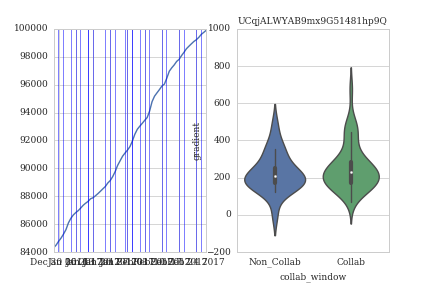

UCqjALWYAB9mx9G51481hp9Q
2017-02-11T18:33:58.000Z 3 ( 2 )
2017-01-26T23:30:00.000Z 3 ( 2 )
2017-01-17T23:31:26.000Z 3 ( 2 )
2016-12-31T19:30:00.000Z 3 ( 2 )
2017-01-07T18:00:00.000Z 3 ( 2 )
2017-01-19T23:30:00.000Z 3 ( 2 )
2017-02-18T19:25:07.000Z 3 ( 2 )
2017-01-03T20:27:04.000Z 3 ( 2 )
2017-02-24T01:07:26.000Z 3 ( 2 )
2017-01-05T21:02:52.000Z 3 ( 2 )
2017-02-02T23:43:55.000Z 3 ( 2 )
2017-02-16T23:20:09.000Z 3 ( 2 )
2017-01-21T20:00:01.000Z 3 ( 2 )
2017-02-04T20:25:24.000Z 3 ( 2 )
2017-02-09T23:30:00.000Z 3 ( 2 )
2017-02-26T00:14:32.000Z 3 ( 2 )
2017-01-28T20:17:37.000Z 3 ( 2 )
2017-01-10T23:30:18.000Z 3 ( 2 )
2017-01-12T23:30:30.000Z 3 ( 2 )
2017-01-28T22:55:45.000Z 2 ( 2 )
2017-01-11T03:13:22.000Z 2 ( 2 )
2017-02-01T00:39:11.000Z 3 ( 2 )
2016-12-29T15:28:24.000Z 3 ( 2 )
2017-01-25T21:40:24.000Z 2 ( 2 )


<IPython.core.display.Javascript object>


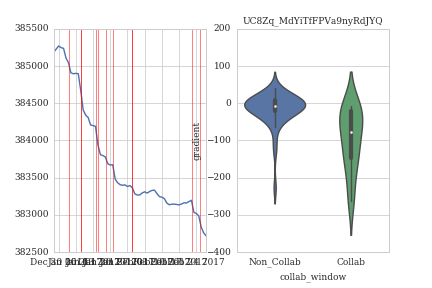

UC8Zq_MdYiTfFPVa9nyRdJYQ
2017-01-08T03:31:39.000Z 3 ( 3 )
2017-01-15T04:38:28.000Z 3 ( 3 )
2017-01-28T22:00:02.000Z 3 ( 3 )
2017-02-22T02:53:41.000Z 3 ( 3 )
2017-01-08T03:31:39.000Z 3 ( 3 )
2017-01-03T06:24:43.000Z 3 ( 3 )
2017-01-21T03:50:44.000Z 3 ( 3 )
2017-01-18T05:34:19.000Z 3 ( 3 )
2017-01-28T22:00:02.000Z 3 ( 3 )
2017-02-25T09:51:56.000Z 3 ( 3 )
2017-01-14T03:13:54.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


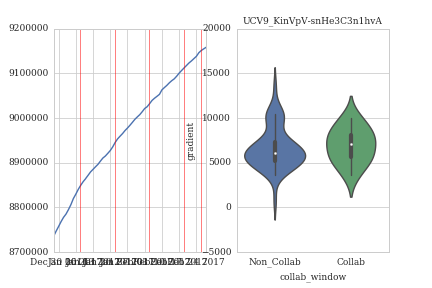

UCV9_KinVpV-snHe3C3n1hvA
2017-02-25T19:56:40.000Z 4 ( 4 )
2017-01-21T19:39:21.000Z 4 ( 4 )
2017-02-18T19:47:11.000Z 4 ( 4 )
2017-02-04T19:42:08.000Z 4 ( 4 )
2017-01-07T19:39:27.000Z 4 ( 4 )


<IPython.core.display.Javascript object>


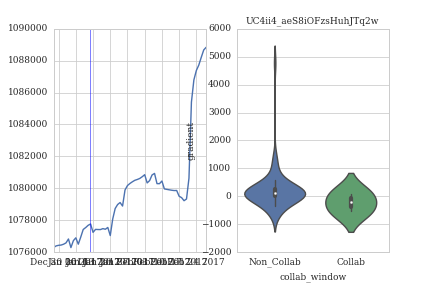

UC4ii4_aeS8iOFzsHuhJTq2w
2017-01-11T18:36:19.000Z 4 ( 4 )


In [16]:
import random


sampled_df_i  = random.sample(channel_collabs_groups.indices, 10)
df_list  = map(lambda df_i: (df_i, channel_collabs_groups.get_group(df_i)), sampled_df_i)


for name, group in df_list:
    videos = []
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    plt.title(name)
    print name
    ax1.plot_date(group['crawlTimestamp'], group['subscriberCount'], 'b-')
    
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['from_popularity']), '(',row['to_popularity'], ')'
                ax1.axvline(x=date, color='red', linewidth=.5)
                videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['to_popularity']), '(',row['from_popularity'], ')'
                ax1.axvline(x=date, color='blue', linewidth=.5)
                videos.append( (vid, date) )

    df_group_videos = pa.DataFrame(videos, columns=['video', 'date'])

    subs = group['subscriberCount'].values
    group.drop(group.index[:1], inplace=True)
    group['gradient'] = np.diff(subs)
    group['collab_window'] = 'Non_Collab'
    
    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))


    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        group.ix[filtered.index, 'collab_window'] = 'Collab'
    
    sns.violinplot(x="collab_window", y="gradient", data=group, ax=ax2) #, order=["Collab", "Non_Collab"])


In [17]:
# fixing zeros in subscriber count for division by zero

for name, group in channel_collabs_groups:
    if 0 in group['subscriberCount'].values:
        print name
        print group['subscriberCount'].values

group = channel_collabs_groups.get_group('UCAvwetms56ntZtQWkYoqEIQ')
subs = group['subscriberCount'].values
subs[subs == 0] = 572346
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCCnms8EieLvB6oNLXBgIGNQ')
subs = group['subscriberCount'].values
subs[subs == 0] = 146262
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCpqDsYwBFQqTuZRYhBUmK0A')
subs = group['subscriberCount'].values
subs[subs == 0] = 2800
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

UCAvwetms56ntZtQWkYoqEIQ
[546248 548027 551486 554313 555090 556796 558217 559072 559662 560287
 561144 562108 563911 565113 565219 566061 566658 567377 567676 567951
 568296 568530 568861 569240 569740 570304 570863 571743 572346      0
 573448 573581 573725 573992 574313 574589 574852 575069 575356 575537
 575580 575714 575865 575954 576613 578184 578853 579285 581299 582487
 583874 585211 586021 586656 587381 588265 589041 589750 590254 591061
 592052 592612 595178 596068]
UCCnms8EieLvB6oNLXBgIGNQ
[147329 147322 147322 147317 147315 147313 147308 147214 147189 147173
 147167 147161 147165 147162 147163 147130 147102 147097 147090 147092
 147084 147077 147058 146972 146962 146934 146914 146899 146890 146853
 146828 146805 146813 146800 146794 146781 146777 146758 146745 146713
 146683 146625 146566 146534 146482 146458 146437 146436 146395 146351
 146323 146291 146281 146284 146262      0      0      0      0      0
      0      0      0      0]
UCpqDsYwBFQqTuZRYhBUmK0A
[   0    0   

In [21]:
# compute subscriber gradient and gradient percentage growth and collaboration window in dataframe

df_channel_history_collabs['gradient'] = np.nan
df_channel_history_collabs['p_gradient'] = np.nan
df_channel_history_collabs['collab_window'] = 'Non_Collab'


for name, group in channel_collabs_groups:
    videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                videos.append( (vid, date) )


    df_group_videos = pa.DataFrame(videos, columns=['video', 'date'])


    subs = group['subscriberCount'].values
    #subs = np.insert(subs, 0, subs[0])
    group.drop(group.index[:1], inplace=True)
    df_channel_history_collabs.ix[group.index, 'gradient'] = np.diff(subs)
    df_channel_history_collabs.ix[group.index, 'p_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(subs[1:], subs)]
    
    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))


    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        df_channel_history_collabs.ix[filtered.index, 'collab_window'] = 'Collab'

print 'Non_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_gradient'].describe()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Non_Collabs:
count     58481.000000
mean       1024.123596
std        5197.779055
min     -557555.000000
25%          32.000000
50%         204.000000
75%         845.000000
max      644558.000000
Name: gradient, dtype: float64

Collabs:
count      8236.000000
mean       1798.116197
std        4931.420489
min      -14731.000000
25%          70.000000
50%         406.000000
75%        1592.250000
max      158155.000000
Name: gradient, dtype: float64

Non_Collabs:
count    58481.000000
mean         0.237552
std          6.739267
min        -22.754245
25%          0.031969
50%          0.094738
75%          0.222607
max       1623.611111
Name: p_gradient, dtype: float64

Collabs:
count    8236.000000
mean        0.270386
std         0.627676
min        -4.054054
25%         0.036037
50%         0.113306
75%         0.289602
max        18.286321
Name: p_gradient, dtype: float64


In [18]:
# compute subscriber gradient and gradient percentage growth and collaboration window in dataframe

df_channel_history_collabs['gradient'] = np.nan
df_channel_history_collabs['p_gradient'] = np.nan
df_channel_history_collabs['collab_window'] = 'NaN'


for name, group in channel_collabs_groups:
    collab_videos = []
    norm_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]


    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])


    subs = group['subscriberCount'].values
    #subs = np.insert(subs, 0, subs[0])
    group.drop(group.index[:1], inplace=True)
    df_channel_history_collabs.ix[group.index, 'gradient'] = np.diff(subs)
    df_channel_history_collabs.ix[group.index, 'p_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(subs[1:], subs)]
    
    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))
    
    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=2))

    
    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        df_channel_history_collabs.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        if (df_channel_history_collabs.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_channel_history_collabs.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_channel_history_collabs.ix[filtered.index, 'collab_window'] = 'Collab'
        
    

print 'Non_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_gradient'].describe()

print '\nNaN:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='NaN']['gradient'].describe()
print '\nNaN:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='NaN']['p_gradient'].describe()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Non_Collabs:
count     27607.000000
mean       1348.789836
std        5417.576534
min     -313264.000000
25%          63.000000
50%         327.000000
75%        1240.000000
max      644558.000000
Name: gradient, dtype: float64

Collabs:
count      5951.000000
mean       1727.602084
std        5169.289909
min      -14731.000000
25%          57.000000
50%         343.000000
75%        1479.000000
max      158155.000000
Name: gradient, dtype: float64

Non_Collabs:
count    27607.000000
mean         0.311520
std          9.797081
min        -17.467286
25%          0.045885
50%          0.119171
75%          0.276467
max       1623.611111
Name: p_gradient, dtype: float64

Collabs:
count    5951.000000
mean        0.258387
std         0.638049
min        -4.054054
25%         0.029655
50%         0.099264
75%         0.275071
max        18.286321
Name: p_gradient, dtype: float64

NaN:
count     33159.000000
mean        819.809283
std        4938.479330
min     -557555.000000
25%          21

In [19]:
len(df_channel_history_collabs[df_channel_history_collabs.gradient.isnull()])


1059

In [20]:
# fixing zeros in view count for division by zero
# no found atm

for name, group in channel_collabs_groups:
    if 0 in group['viewCount'].values:
        print name
        print group['viewCount'].values

In [21]:
# compute viewcount gradient and percentage gradient for channel

df_channel_history_collabs['viewCount_gradient'] = np.nan
df_channel_history_collabs['p_viewCount_gradient'] = np.nan

for name, group in channel_collabs_groups:
    views = group['viewCount'].values
    group.drop(group.index[:1], inplace=True)
    df_channel_history_collabs.ix[group.index, 'viewCount_gradient'] = np.diff(views)
    df_channel_history_collabs.ix[group.index, 'p_viewCount_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(views[1:], views)]


print 'Non_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['viewCount_gradient'].describe()

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_viewCount_gradient'].describe()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Non_Collabs:
count    2.760700e+04
mean     2.774089e+05
std      1.432119e+07
min     -2.371137e+09
25%      1.003800e+04
50%      6.599300e+04
75%      2.618605e+05
max      3.374078e+07
Name: viewCount_gradient, dtype: float64

Collabs:
count    5.951000e+03
mean     3.269244e+05
std      1.760541e+06
min     -1.148783e+08
25%      8.790855e+03
50%      5.613300e+04
75%      2.481575e+05
max      1.987803e+07
Name: viewCount_gradient, dtype: float64

Non_Collabs:
count    27607.000000
mean         0.305633
std          1.602330
min        -70.044795
25%          0.070997
50%          0.164918
75%          0.356138
max        223.310737
Name: p_viewCount_gradient, dtype: float64

Collabs:
count    5951.000000
mean        0.317501
std         1.272698
min       -57.961738
25%         0.057154
50%         0.136852
75%         0.338401
max        29.315961
Name: p_viewCount_gradient, dtype: float64


In [22]:
df_channel_history_collabs[df_channel_history_collabs.gradient.isnull()].head()

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,p_gradient,collab_window,viewCount_gradient,p_viewCount_gradient
id,,,,,,,,,,,
7950,UC__Pj66OeDibNZNN__L913g,3253022.0,23029,0,967,2016-12-28 03:03:17,NaN,NaN,NaN,NaN,NaN
7826,UC_1H9v258pXiyLDaW0R5exw,23526135.0,86815,0,863,2016-12-28 03:03:12,NaN,NaN,NaN,NaN,NaN
7824,UC_1HVMnw-610qx54iEiWk7A,64671535.0,747026,0,200,2016-12-28 03:03:12,NaN,NaN,NaN,NaN,NaN
7829,UC_3gH6zKpk3aCkRkiTik5JA,11777688.0,85150,7,351,2016-12-28 03:03:12,NaN,NaN,NaN,NaN,NaN
7833,UC_6TY1I5afGbaSZqTcHmPZA,78782195.0,74573,0,952,2016-12-28 03:03:12,NaN,NaN,NaN,NaN,NaN


In [23]:
df_channel_history_collabs[df_channel_history_collabs.p_gradient > 1000]

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,p_gradient,collab_window,viewCount_gradient,p_viewCount_gradient
id,,,,,,,,,,,
44365,UCmuBqEMBGe1SKWlF33JUz0w,1710.0,2482,0,19,2017-01-02 00:03:39,2338.0,1623.611111,Non_Collab,11.0,0.64744


In [24]:
# remove single outlier testwise
df_channel_history_collabs.dropna(subset=['gradient', 'viewCount_gradient'], inplace=True)
df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.p_gradient < 1000]
channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_gradient'].describe()


Non_Collabs:
count    27606.000000
mean         0.252718
std          0.724848
min        -17.467286
25%          0.045884
50%          0.119170
75%          0.276455
max         60.072522
Name: p_gradient, dtype: float64

Collabs:
count    5951.000000
mean        0.258387
std         0.638049
min        -4.054054
25%         0.029655
50%         0.099264
75%         0.275071
max        18.286321
Name: p_gradient, dtype: float64


In [26]:
df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.p_viewCount_gradient < 100]

In [27]:
#df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.p_viewCount_gradient < 200]
#df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.viewCount_gradient < 1.0e+08]
channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_viewCount_gradient'].describe()


Non_Collabs:
count    27605.000000
mean         0.297542
std          0.875204
min        -70.044795
25%          0.070995
50%          0.164895
75%          0.356082
max         29.489489
Name: p_viewCount_gradient, dtype: float64

Collabs:
count    5951.000000
mean        0.317501
std         1.272698
min       -57.961738
25%         0.057154
50%         0.136852
75%         0.338401
max        29.315961
Name: p_viewCount_gradient, dtype: float64


<IPython.core.display.Javascript object>


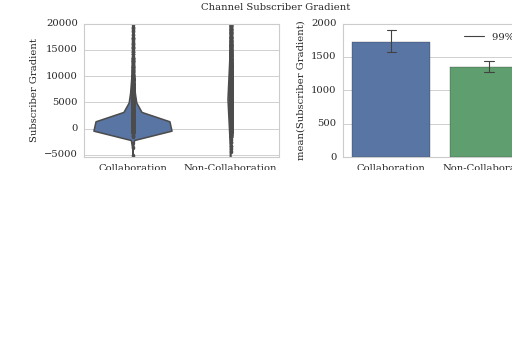

<IPython.core.display.Javascript object>


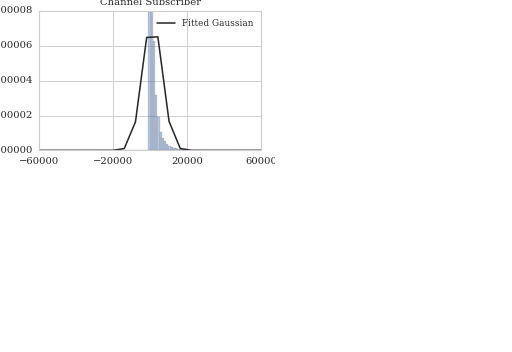

Normal-dist-test: NormaltestResult(statistic=169964.24844095888, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=83096889.5, pvalue=0.15743565547726712) 
p*2: 0.314871310955
Wilcoxon rank-sum-test: RanksumsResult(statistic=1.4137473815573263, pvalue=0.15743608803785181) 
p*2: 0.314872176076


In [74]:
# Boxplot subscriberCount gradient for collab channel 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'], inner='point')
sns.barplot(x="collab_window", y="gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Subscriber Gradient')
ax2.set_ylabel('mean(Subscriber Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Subscriber Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-5500.0, 20000.0])
save_plot('collab_channel_subscriber_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['gradient'])

fig = plt.figure()
ax = sns.distplot(test['gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["$\mu=${0:.2g}, $\sigma=${1:.2f}".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
ax.set_ylim([0.0, 0.00008])
ax.set_xlim([-60000.0, 60000.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_channel_subscriber_norm_fit.pdf', fig, s_width, s_height)
print 'Normal-dist-test:', normaltest(test['gradient'])

collabs_grads = test[test.collab_window == 'Collab']['gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


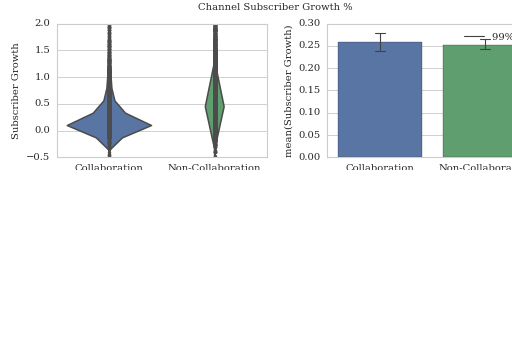

<IPython.core.display.Javascript object>


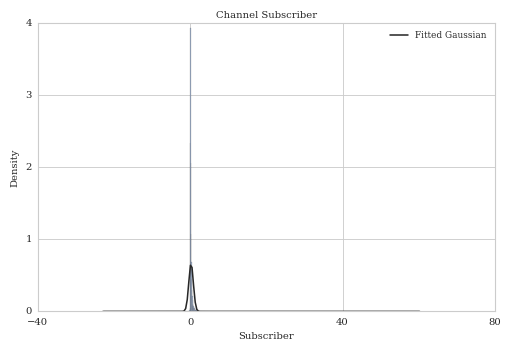

Normal-dist-test: NormaltestResult(statistic=174924.28798827963, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=77039766.5, pvalue=5.3557328238459963e-14) 
p*2: 1.07114656477e-13
Wilcoxon rank-sum-test: RanksumsResult(statistic=-7.5229407219319393, pvalue=5.3557710394185707e-14) 
p*2: 1.07115420788e-13


In [86]:
# Boxplot subscriberCount percentage gradient for collab channel 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'], inner='point')
sns.barplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Subscriber Growth')
ax2.set_ylabel('mean(Subscriber Growth)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Subscriber Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-0.5, 2.0])
save_plot('collab_channel_subscriber_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["p_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()
#ax.set_ylim([0.0, 0.00008])
#ax.set_xlim([-60000.0, 60000.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
#save_plot('collab_channel_subscriber_norm_fit_perc.pdf', fig, s_width, s_height)

print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


In [34]:
print '\nCollab only channel'
print 'Number of values:', len(df_channel_history_collabs)
print 'Number of non_collab values:', len(df_channel_history_collabs[df_channel_history_collabs.collab_window == 'Non_Collab'])
print 'Number of collab values:', len(df_channel_history_collabs[df_channel_history_collabs.collab_window == 'Collab'])


Collab only channel
Number of values: 66715
Number of non_collab values: 27605
Number of collab values: 5951


<IPython.core.display.Javascript object>


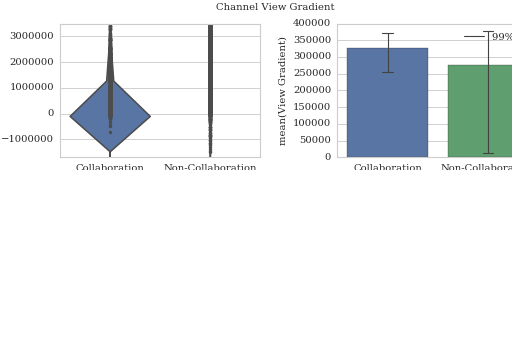

<IPython.core.display.Javascript object>


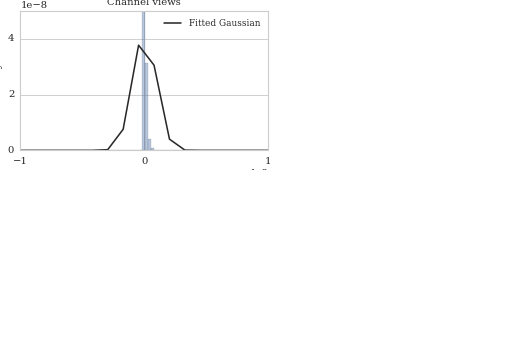

Normal-dist-test: NormaltestResult(statistic=348598.82480112236, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=80058438.5, pvalue=0.0021407658505142387) 
p*2: 0.00428153170103
Wilcoxon rank-sum-test: RanksumsResult(statistic=-3.0691876529029387, pvalue=0.0021464172223233441) 
p*2: 0.00429283444465


In [90]:
# Boxplot viewCount gradient for collab channel

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="viewCount_gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'], inner='point')
sns.barplot(x="collab_window", y="viewCount_gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Gradient')
ax2.set_ylabel('mean(View Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel View Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-1700000.0, 3500000.0])
save_plot('collab_channel_fixed_view_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["viewCount_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['viewCount_gradient'])

fig = plt.figure()
ax = sns.distplot(test['viewCount_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Channel views')
plt.tight_layout()
ax.set_ylim([0.0, 5.0e-8])
ax.set_xlim([-1.0e+8, 1.0e+8])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_channel_fixed_view_norm_fit_perc.pdf', fig, s_width, s_height)
print 'Normal-dist-test:', normaltest(test['viewCount_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['viewCount_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['viewCount_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


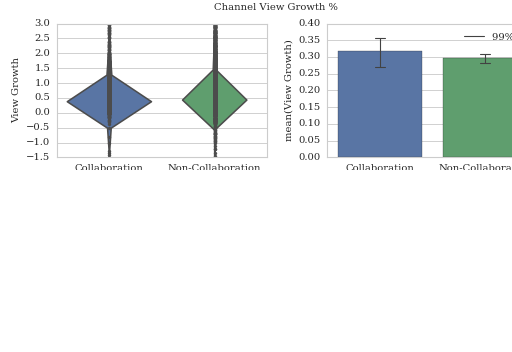

<IPython.core.display.Javascript object>


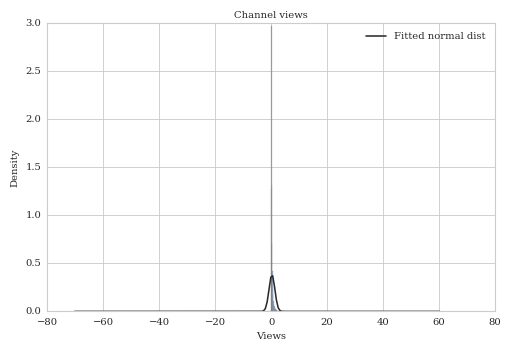

Normal-dist-test: NormaltestResult(statistic=36221.702589618508, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=77147637.5, pvalue=1.7624861394539628e-13) 
p*2: 3.52497227891e-13
Wilcoxon rank-sum-test: RanksumsResult(statistic=-7.3637876912915692, pvalue=1.7876393017989457e-13) 
p*2: 3.5752786036e-13


In [95]:
# Boxplot viewCount percentage gradient for collab channel

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'], inner='point')
sns.barplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Growth')
ax2.set_ylabel('mean(View Growth)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel View Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-1.5, 03.00])
save_plot('collab_channel_fixed_view_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["p_viewCount_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_viewCount_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_viewCount_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Channel views')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['p_viewCount_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_viewCount_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_viewCount_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


In [43]:
df_channel_history_collabs.head(5)

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,p_gradient,collab_window,viewCount_gradient,p_viewCount_gradient
id,,,,,,,,,,,
15901,UC__Pj66OeDibNZNN__L913g,3256817.0,23051,0,967,2016-12-29 00:06:15,22.0,0.095532,NaN,3795.0,0.116661
23850,UC__Pj66OeDibNZNN__L913g,3260384.0,23111,0,966,2016-12-30 00:06:10,60.0,0.260292,NaN,3567.0,0.109524
31804,UC__Pj66OeDibNZNN__L913g,3263870.0,23187,0,965,2016-12-31 00:06:06,76.0,0.328848,NaN,3486.0,0.106920
39756,UC__Pj66OeDibNZNN__L913g,3266664.0,23206,0,965,2017-01-01 00:06:14,19.0,0.081942,NaN,2794.0,0.085604
47705,UC__Pj66OeDibNZNN__L913g,3269733.0,23227,0,965,2017-01-02 00:06:11,21.0,0.090494,NaN,3069.0,0.093949


In [44]:
# Try new method, instead of fixing the anomaly viewcount bug
# Use video view history to sum daily viewcount for every channel

# group history by channel
# group channel groups by day
# sum viewcount per day group -> daily viewcount per channel -> gradient

In [45]:
# Read history data from  DB
with db._session_scope(False) as session:

    df_video_history = pa.read_sql(session.query(VideoHistory, Video.channelID).filter(VideoHistory.videoID==Video.id).statement, db.engine)


df_video_history = df_video_history.set_index(['id'])
df_video_history['crawlTimestamp'] = df_video_history['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))


#df_video_history.head()

In [46]:
# Create new column with just crawl date (day, no time)
# so we can group all video viewcounts by day -> sum these
df_video_history['crawlDate'] = df_video_history['crawlTimestamp'].apply(lambda x: x.date())
df_video_history.head()

,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp,channelID,crawlDate
id,,,,,,,,
2508759,_GDOhRsQ9KQ,125,0,6,0,2017-02-18 00:08:33,UC__Pj66OeDibNZNN__L913g,2017-02-18
2611688,_GDOhRsQ9KQ,273,0,8,0,2017-02-19 00:16:59,UC__Pj66OeDibNZNN__L913g,2017-02-19
2713841,_GDOhRsQ9KQ,327,0,9,0,2017-02-20 00:17:07,UC__Pj66OeDibNZNN__L913g,2017-02-20
2817915,_GDOhRsQ9KQ,387,0,9,0,2017-02-21 00:15:05,UC__Pj66OeDibNZNN__L913g,2017-02-21
2923911,_GDOhRsQ9KQ,471,0,9,0,2017-02-22 00:15:43,UC__Pj66OeDibNZNN__L913g,2017-02-22


In [31]:
# group by channel then by day, sum all daily view counts
# runs some time
video_channel_groups = df_video_history.groupby(['channelID'])

df_video_channel_viewcounts = []

for name, group in video_channel_groups:
    days = group.groupby(['crawlDate'])
    
    for dname, dgroup in days:
        df_video_channel_viewcounts.append( (name, dname, dgroup['viewCount'].sum()))
    

df_video_channel_viewcounts = pa.DataFrame(df_video_channel_viewcounts, columns=['channelID', 'date', 'viewCount'])

df_video_channel_viewcounts.head()


KeyboardInterrupt: 

In [48]:
# save to file
#df_video_channel_viewcounts.to_csv(DIR+r'/df_video_channel_viewcounts.txt', sep=str('\t'), encoding='utf-8')
df_video_channel_viewcounts = pa.read_csv(DIR+r'/df_video_channel_viewcounts.txt', sep=str('\t'), encoding='utf-8', index_col=0)
df_video_channel_viewcounts['date'] = df_video_channel_viewcounts['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

print 'Nof Value points in new videoviews based (All channel):', len(df_video_channel_viewcounts)
print df_video_channel_viewcounts['channelID'].nunique()

print 'Nof Value points in channel based (collab only channel):', len(df_channel_history_collabs)
print df_channel_history_collabs['channelID'].nunique()


df_video_channel_viewcounts_collabs = df_video_channel_viewcounts[ (df_video_channel_viewcounts.channelID.isin(df_graph_filtered['from'].tolist())) | (df_video_channel_viewcounts.channelID.isin(df_graph_filtered['to'].tolist()))]
print 'Nof Value points in new videoviews based (collab channel):', len(df_video_channel_viewcounts_collabs)
print df_video_channel_viewcounts_collabs['channelID'].nunique()

Nof Value points in new videoviews based (All channel): 289233
5466
Nof Value points in channel based (collab only channel): 66715
1059
Nof Value points in new videoviews based (collab channel): 60496
1059


<IPython.core.display.Javascript object>


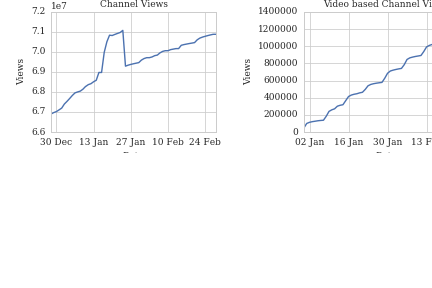

64
60


In [49]:
#bug_group = channel_collabs_groups.get_group('UCavTVjugW1OejDAq0aDzdMw')
bug_group = unfixed_channel_collabs_groups.get_group('UCavTVjugW1OejDAq0aDzdMw')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot_date(bug_group['crawlTimestamp'], bug_group['viewCount'], 'b-')
ax1.set_title('Channel Views')
video_views = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.channelID=='UCavTVjugW1OejDAq0aDzdMw']
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_xlabel('Date')
ax1.set_ylabel('Views')

ax2.plot_date(video_views['date'], video_views['viewCount'], 'b-')
ax2.set_title('Video based Channel Views')
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_xlabel('Date')
ax2.set_ylabel('Views')

fmt = DateFormatter("%d %b")
ax1.xaxis.set_major_formatter(fmt)
ax2.xaxis.set_major_formatter(fmt)

fig.tight_layout()
save_plot('collab_channel_video_based_views_sample.pdf', fig, 2*s_width, s_height)

print len(bug_group)
print len(video_views)

#bug_group['gradient'] = np.gradient(bug_group['viewCount'])
#video_views['gradient'] =np.gradient(video_views['viewCount'])

#print bug_group['gradient']
#print '\n'
#print video_views['gradient']


In [ ]:
# compute channel viewcount gradients and percentage gradient for video based channel view counts

video_channel_view_groups = df_video_channel_viewcounts_collabs.groupby(['channelID'])

df_video_channel_viewcounts_collabs['gradient'] = np.nan
df_video_channel_viewcounts_collabs['p_gradient'] = np.nan
df_video_channel_viewcounts_collabs['collab_window'] = 'NaN'

cnt=0

for name, group in video_channel_view_groups:
    
    if len(group['viewCount']) < 2:
        cnt += 1
        continue
    
    collab_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]


    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])

    subs = group['viewCount'].values
    group.drop(group.index[:1], inplace=True)
    df_video_channel_viewcounts_collabs.ix[group.index, 'gradient'] = np.diff(subs)
    df_video_channel_viewcounts_collabs.ix[group.index, 'p_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(subs[1:], subs)]

    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))

    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=2))



    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        if (df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] = 'Collab'
        
        
print cnt

print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['p_gradient'].describe()

print '\NaN:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='NaN']['gradient'].describe()
print '\nNaN:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='NaN']['p_gradient'].describe()


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [54]:
df_video_channel_viewcounts_collabs.to_csv(DIR+r'/df_video_channel_collabs_viewcounts.txt', sep=str('\t'), encoding='utf-8')
#df_video_channel_viewcounts_collabs = pa.read_csv(DIR+r'/df_video_channel_collabs_viewcounts.txt', sep=str('\t'), encoding='utf-8', index_col=0)
#df_video_channel_viewcounts_collabs['date'] = df_video_channel_viewcounts_collabs['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())


print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['p_gradient'].describe()

df_video_channel_viewcounts_collabs.head()

Non_Collabs:
count    1.862900e+04
mean     1.957506e+05
std      5.075590e+05
min     -3.776084e+06
25%      8.637000e+03
50%      4.357800e+04
75%      1.645580e+05
max      1.174678e+07
Name: gradient, dtype: float64

Collabs:
count    3.061000e+03
mean     1.650841e+05
std      4.500703e+05
min     -1.084490e+05
25%      5.671000e+03
50%      3.088800e+04
75%      1.449300e+05
max      1.165972e+07
Name: gradient, dtype: float64

Non_Collabs:
count    18629.000000
mean        17.891612
std        132.258083
min        -89.448636
25%          2.732066
50%          4.864546
75%         10.655758
max      10392.913386
Name: p_gradient, dtype: float64

Collabs:
count     3061.000000
mean        25.410838
std        457.638628
min        -41.646873
25%          2.344848
50%          4.470987
75%         10.476459
max      23556.737589
Name: p_gradient, dtype: float64


,channelID,date,viewCount,gradient,p_gradient,collab_window
591,UC-A4oZF4AlOEdlyZWBCI0cQ,2016-12-30,53936,NaN,NaN,NaN
592,UC-A4oZF4AlOEdlyZWBCI0cQ,2016-12-31,88561,34625.0,64.196455,NaN
593,UC-A4oZF4AlOEdlyZWBCI0cQ,2017-01-01,101401,12840.0,14.498481,NaN
594,UC-A4oZF4AlOEdlyZWBCI0cQ,2017-01-02,109714,8313.0,8.198144,NaN
595,UC-A4oZF4AlOEdlyZWBCI0cQ,2017-01-03,117451,7737.0,7.051971,NaN


In [96]:
df_video_channel_viewcounts_collabs = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.p_gradient < 23000]
df_video_channel_viewcounts_collabs.dropna(subset=['gradient'], inplace=True)
print '\nNon_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['p_gradient'].describe()


Non_Collabs:
count    18629.000000
mean        17.891612
std        132.258083
min        -89.448636
25%          2.732066
50%          4.864546
75%         10.655758
max      10392.913386
Name: p_gradient, dtype: float64

Collabs:
count    3060.000000
mean       17.720862
std       168.605838
min       -41.646873
25%         2.344791
50%         4.466047
75%        10.465388
max      8462.394958
Name: p_gradient, dtype: float64


In [97]:
df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.p_gradient > 10000]

df_video_channel_viewcounts_collabs = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.p_gradient < 23000]

<IPython.core.display.Javascript object>


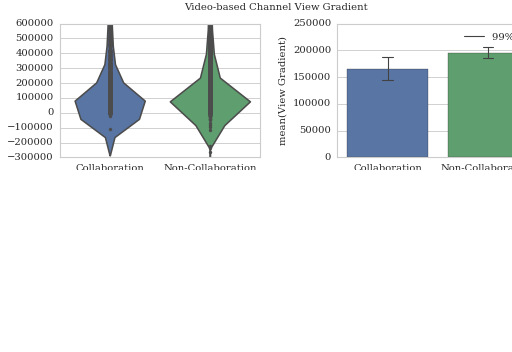

<IPython.core.display.Javascript object>


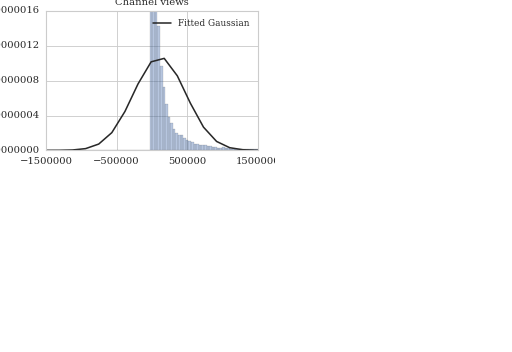

Normal-dist-test: NormaltestResult(statistic=68076.30143228294, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=26430869.5, pvalue=1.0934977225568561e-10) 
p*2: 2.18699544511e-10
Wilcoxon rank-sum-test: RanksumsResult(statistic=-6.453427046453232, pvalue=1.0934865422718797e-10) 
p*2: 2.18697308454e-10


In [103]:
# Boxplot video-based viewcount gradient for all collab channel 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="gradient", data=df_video_channel_viewcounts_collabs, ax=ax1, order=['Collab', 'Non_Collab'], inner='point')
sns.barplot(x="collab_window", y="gradient", data=df_video_channel_viewcounts_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Gradient')
ax2.set_ylabel('mean(View Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-300000.0, 600000.0])
save_plot('collab_channel_video_based_view_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs["gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['gradient'])

fig = plt.figure()
ax = sns.distplot(test['gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Channel views')
plt.tight_layout()
ax.set_ylim([0.0, 1.6e-6])
ax.set_xlim([-1.5e+6, 1.5e+6])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_channel_video_based_view_norm_fit.pdf', fig, s_width, s_height)

print 'Normal-dist-test:', normaltest(test['gradient'])

collabs_grads = test[test.collab_window == 'Collab']['gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


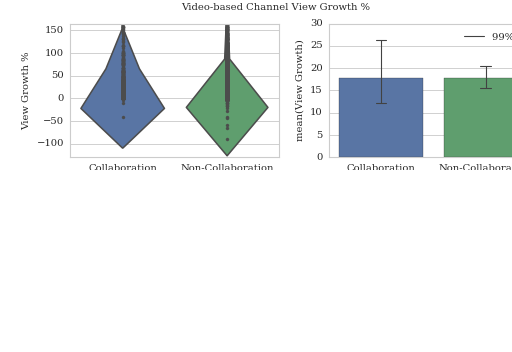

<IPython.core.display.Javascript object>


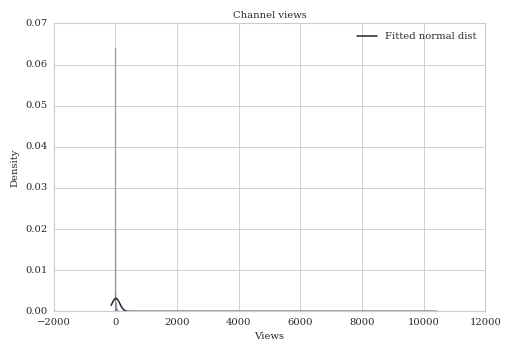

Normal-dist-test: NormaltestResult(statistic=178919.46794464582, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=26833416.5, pvalue=1.9998128828699838e-07) 
p*2: 3.99962576574e-07
Wilcoxon rank-sum-test: RanksumsResult(statistic=-5.1993565322203805, pvalue=1.9997961254662204e-07) 
p*2: 3.99959225093e-07


In [108]:
# Boxplot video-based viewcount percentage gradient for all collab channel 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs, ax=ax1, order=['Collab', 'Non_Collab'], inner='point')
sns.barplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Growth %')
ax2.set_ylabel('mean(View Growth)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-130.0, 165.0])
save_plot('collab_channel_video_based_view_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs["p_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Channel views')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


In [109]:
# new method
# do gradient day-wise, create 6 day plot with 6 double bars, collab, non_collab
# every bar is gradient of that day (the day x after collab)

# create dataframe accordingly

df_channel_history_collabs.head()

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,p_gradient,collab_window,viewCount_gradient,p_viewCount_gradient
id,,,,,,,,,,,
15901,UC__Pj66OeDibNZNN__L913g,3256817.0,23051,0,967,2016-12-29 00:06:15,22.0,0.095532,NaN,3795.0,0.116661
23850,UC__Pj66OeDibNZNN__L913g,3260384.0,23111,0,966,2016-12-30 00:06:10,60.0,0.260292,NaN,3567.0,0.109524
31804,UC__Pj66OeDibNZNN__L913g,3263870.0,23187,0,965,2016-12-31 00:06:06,76.0,0.328848,NaN,3486.0,0.106920
39756,UC__Pj66OeDibNZNN__L913g,3266664.0,23206,0,965,2017-01-01 00:06:14,19.0,0.081942,NaN,2794.0,0.085604
47705,UC__Pj66OeDibNZNN__L913g,3269733.0,23227,0,965,2017-01-02 00:06:11,21.0,0.090494,NaN,3069.0,0.093949


In [111]:
# add information to dataframe which day after collab it is

df_channel_history_collabs_days = df_channel_history_collabs.copy()

channel_collabs_days_group = df_channel_history_collabs_days.groupby(['channelID'])

df_channel_history_collabs_days['collab_window'] = 'NaN'
df_channel_history_collabs_days['day_after'] = -1

for name, group in channel_collabs_days_group:
    collab_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]

    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])

    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=6))
    
    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=6))

    
    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        if (df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'Collab'
        # create new column day_after, with 0 to 6 day after collab value
        df_channel_history_collabs_days.ix[filtered.index, 'day_after']  = filtered['crawlTimestamp'].apply(lambda x: (x-date).days)
    

df_channel_history_collabs_days.head()

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,p_gradient,collab_window,viewCount_gradient,p_viewCount_gradient,day_after
id,,,,,,,,,,,,
15901,UC__Pj66OeDibNZNN__L913g,3256817.0,23051,0,967,2016-12-29 00:06:15,22.0,0.095532,NaN,3795.0,0.116661,-1
23850,UC__Pj66OeDibNZNN__L913g,3260384.0,23111,0,966,2016-12-30 00:06:10,60.0,0.260292,NaN,3567.0,0.109524,-1
31804,UC__Pj66OeDibNZNN__L913g,3263870.0,23187,0,965,2016-12-31 00:06:06,76.0,0.328848,NaN,3486.0,0.106920,-1
39756,UC__Pj66OeDibNZNN__L913g,3266664.0,23206,0,965,2017-01-01 00:06:14,19.0,0.081942,NaN,2794.0,0.085604,-1
47705,UC__Pj66OeDibNZNN__L913g,3269733.0,23227,0,965,2017-01-02 00:06:11,21.0,0.090494,NaN,3069.0,0.093949,-1


In [112]:
df_channel_history_collabs_days.head()

df_channel_history_collabs_days.day_after.unique()

df_channel_history_collabs_days.p_gradient.describe()

count    66715.000000
mean         0.217267
std          0.598689
min        -22.754245
25%          0.032358
50%          0.096492
75%          0.230149
max         60.072522
Name: p_gradient, dtype: float64

In [113]:
df_channel_history_collabs_days[df_channel_history_collabs_days.p_gradient > 30]

#df_channel_history_collabs_days_cop = df_channel_history_collabs_days[df_channel_history_collabs_days.p_gradient < 1000]

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,p_gradient,collab_window,viewCount_gradient,p_viewCount_gradient,day_after
id,,,,,,,,,,,,
444845,UC3FZmaEFoeMneQa1fubP74g,29793.000000,3468,0,34,2017-02-21 00:00:38,942.0,37.292162,Non_Collab,26.000000,0.087345,-1
452762,UC3FZmaEFoeMneQa1fubP74g,29838.000000,4639,0,34,2017-02-22 00:00:39,1171.0,33.765859,Non_Collab,45.000000,0.151042,-1
52314,UCmuBqEMBGe1SKWlF33JUz0w,1750.000000,3973,0,19,2017-01-03 00:03:38,1491.0,60.072522,Non_Collab,40.000000,2.339181,-1
198389,UCZ30pt71ahOkpINeSSGfC7Q,16881.866556,255,10,9,2017-01-20 00:07:34,60.0,30.769231,Collab,88.228057,0.525366,2


<IPython.core.display.Javascript object>


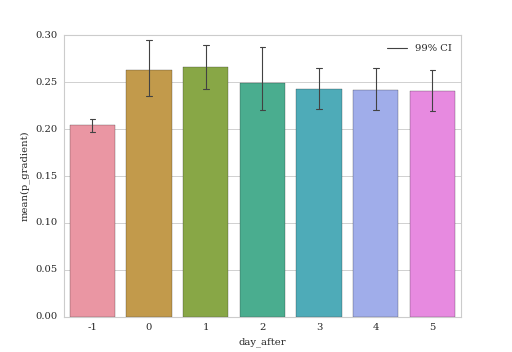

In [114]:
fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1)
plt.legend(["{}% CI".format(99)])

<IPython.core.display.Javascript object>


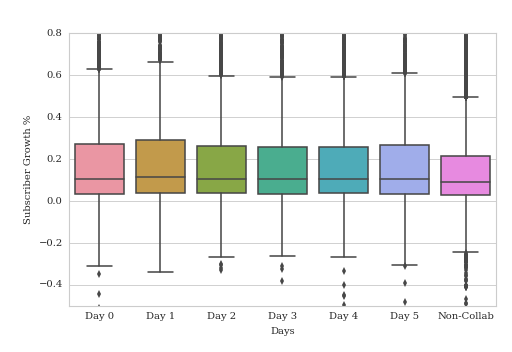

<IPython.core.display.Javascript object>


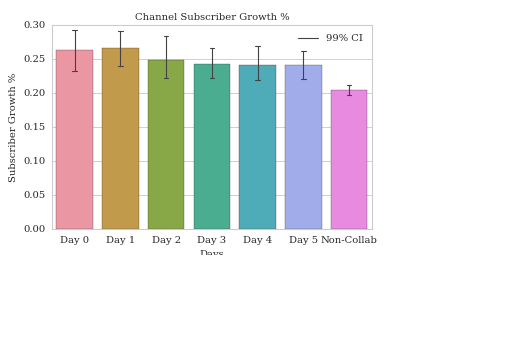

<IPython.core.display.Javascript object>


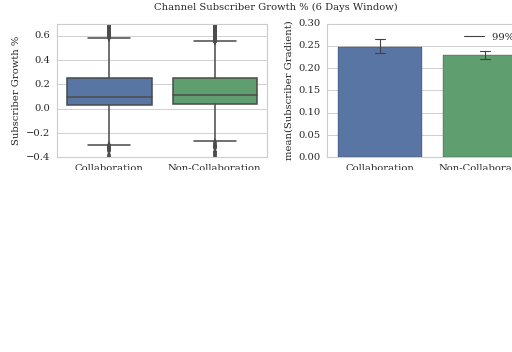

Non_Collabs:
count    34327.000000
mean         0.229755
std          0.650743
min        -17.467286
25%          0.042090
50%          0.110618
75%          0.249116
max         60.072522
Name: p_gradient, dtype: float64

Collabs:
count    12987.000000
mean         0.247880
std          0.631503
min         -4.054054
25%          0.031737
50%          0.098240
75%          0.252603
max         30.769231
Name: p_gradient, dtype: float64


<IPython.core.display.Javascript object>


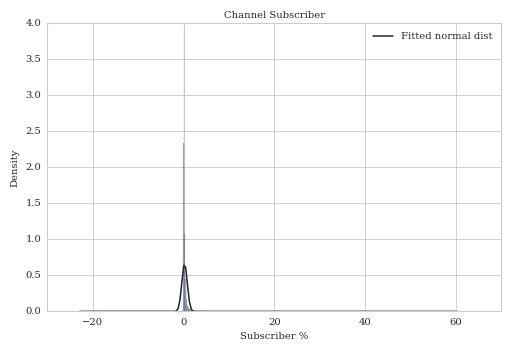

Normal-dist-test: NormaltestResult(statistic=174924.28798827963, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=215221094.5, pvalue=6.8870873390610844e-09) 
p*2: 1.37741746781e-08
Wilcoxon rank-sum-test: RanksumsResult(statistic=-5.7936526205389827, pvalue=6.8871839639948601e-09) 
p*2: 1.3774367928e-08


In [119]:
fig = plt.figure()
ax = sns.boxplot(x=df_channel_history_collabs_days["day_after"], y=df_channel_history_collabs_days["p_gradient"], order=[0, 1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Subscriber Growth %')
ax.set_ylim([-0.5, 0.8])
#plt.title('Channel Subscriber Growth %')
save_plot('collab_channel_6days_subscriber_box_perc.pdf', fig, x_width, x_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, order=[0, 1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax1.set_xlabel('Days')
ax1.set_ylabel('Subscriber Growth %')
plt.legend(["{}% CI".format(99)])
plt.title('Channel Subscriber Growth %')
save_plot('collab_channel_6days_subscriber_ci_perc_s.pdf', fig, 1.5*s_width, 1.5*s_height)


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs_days, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Subscriber Growth %')
ax2.set_ylabel('mean(Subscriber Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Subscriber Growth % (6 Days Window)')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-0.4, 0.7])
save_plot('collab_channel_6days_subscriber_box_ci_perc.pdf', fig, 2*s_width, s_height)

print 'Non_Collabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Collab']['p_gradient'].describe()

test = df_channel_history_collabs_days
# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber %')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

In [120]:
# Boxplot viewCount gradient for collab channel (only channel with collabs)

print 'Non_Collabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Collab']['p_viewCount_gradient'].describe()


#df_channel_history_collabs_days_cop.head()

Non_Collabs:
count    34327.000000
mean         0.296716
std          0.985685
min        -70.044795
25%          0.067998
50%          0.159702
75%          0.349048
max         53.161104
Name: p_viewCount_gradient, dtype: float64

Collabs:
count    12987.000000
mean         0.342015
std          1.182104
min        -57.961738
25%          0.058557
50%          0.139529
75%          0.345086
max         35.382555
Name: p_viewCount_gradient, dtype: float64


<IPython.core.display.Javascript object>


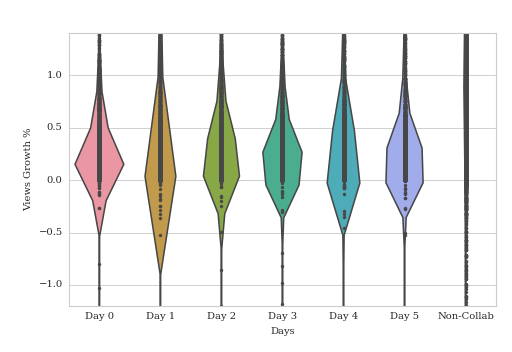

<IPython.core.display.Javascript object>


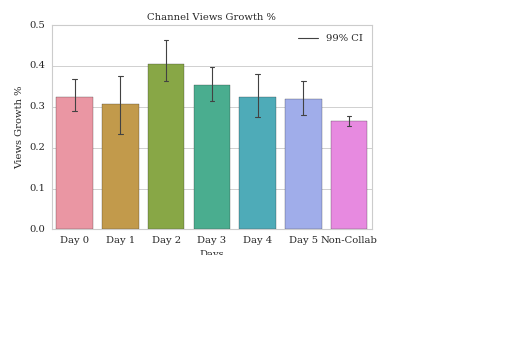

<IPython.core.display.Javascript object>


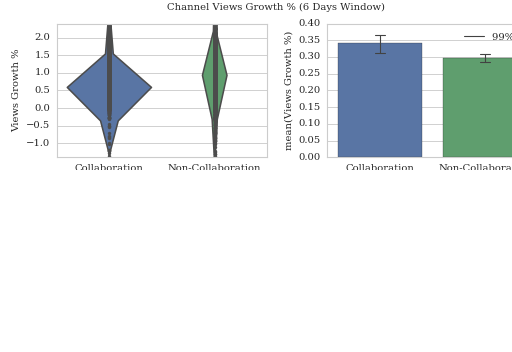

Non_Collabs:
count    34327.000000
mean         0.296716
std          0.985685
min        -70.044795
25%          0.067998
50%          0.159702
75%          0.349048
max         53.161104
Name: p_viewCount_gradient, dtype: float64

Collabs:
count    12987.000000
mean         0.342015
std          1.182104
min        -57.961738
25%          0.058557
50%          0.139529
75%          0.345086
max         35.382555
Name: p_viewCount_gradient, dtype: float64


<IPython.core.display.Javascript object>


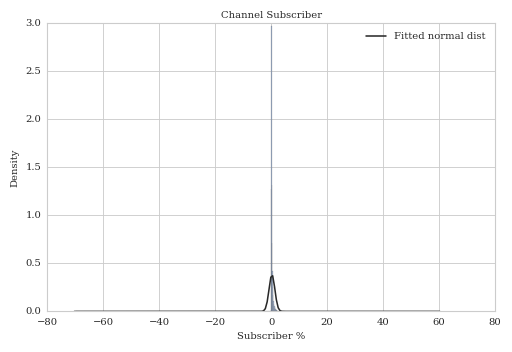

Normal-dist-test: NormaltestResult(statistic=36221.702589618508, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=214521048.5, pvalue=2.5592623365021546e-10) 
p*2: 5.118524673e-10
Wilcoxon rank-sum-test: RanksumsResult(statistic=-6.321666615914471, pvalue=2.5875716984375034e-10) 
p*2: 5.17514339688e-10


In [123]:
fig = plt.figure()
ax = sns.violinplot(x=df_channel_history_collabs_days["day_after"], y=df_channel_history_collabs_days["p_viewCount_gradient"], inner='point', order=[0, 1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views Growth %')
ax.set_ylim([-1.2, 1.4])
save_plot('collab_channel_6days_views_box_perc_violin.pdf', fig, x_width, x_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_viewCount_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, order=[0, 1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('Days')
ax1.set_ylabel('Views Growth %')
plt.title('Channel Views Growth %')
save_plot('collab_channel_6days_views_ci_perc_s.pdf', fig, 1.5*s_width, 1.5*s_height)


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs_days, ax=ax1, inner='point', order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views Growth %')
ax2.set_ylabel('mean(Views Growth %)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Views Growth % (6 Days Window)')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-1.4, 2.4])
save_plot('collab_channel_6days_views_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

print 'Non_Collabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Collab']['p_viewCount_gradient'].describe()

test = df_channel_history_collabs_days
# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_viewCount_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_viewCount_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber %')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['p_viewCount_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_viewCount_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_viewCount_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

In [124]:
df_video_channel_viewcounts_collabs.head()

,channelID,date,viewCount,gradient,p_gradient,collab_window
592,UC-A4oZF4AlOEdlyZWBCI0cQ,2016-12-31,88561,34625.0,64.196455,NaN
593,UC-A4oZF4AlOEdlyZWBCI0cQ,2017-01-01,101401,12840.0,14.498481,NaN
594,UC-A4oZF4AlOEdlyZWBCI0cQ,2017-01-02,109714,8313.0,8.198144,NaN
595,UC-A4oZF4AlOEdlyZWBCI0cQ,2017-01-03,117451,7737.0,7.051971,NaN
596,UC-A4oZF4AlOEdlyZWBCI0cQ,2017-01-04,124087,6636.0,5.650016,NaN


In [ ]:
# add information to dataframe which day after collab it is

df_channel_history_collabs_days = df_channel_history_collabs.copy()

channel_collabs_days_group = df_channel_history_collabs_days.groupby(['channelID'])

df_channel_history_collabs_days['collab_window'] = 'NaN'
df_channel_history_collabs_days['day_after'] = -1

for name, group in channel_collabs_days_group:
    collab_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]

    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])

    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=6))
    
    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=6))

    
    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        if (df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'Collab'
        # create new column day_after, with 0 to 6 day after collab value
        df_channel_history_collabs_days.ix[filtered.index, 'day_after']  = filtered['crawlTimestamp'].apply(lambda x: (x-date).days)
    

df_channel_history_collabs_days.head()

In [125]:
# same as above with video based viewcounts too


df_video_channel_viewcounts_collabs_days = df_video_channel_viewcounts_collabs.copy()

video_channel_view_groups = df_video_channel_viewcounts_collabs_days.groupby(['channelID'])


df_video_channel_viewcounts_collabs_days['collab_window'] = 'NaN'
df_video_channel_viewcounts_collabs_days['day_after'] = -1

cnt=0

for name, group in video_channel_view_groups:
    
    if len(group['viewCount']) < 2:
        cnt += 1
        continue
    
    collab_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]

    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])

    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=6))
    
    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=6))

        
    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        if (df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] = 'Collab'
        # create new column day_after, with 0 to 6 day after collab value
        df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'day_after']  = filtered['date'].apply(lambda x: (x-date.date()).days)
    
        
        
        
print cnt

print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Collab']['gradient'].describe()

print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Collab']['p_gradient'].describe()


1
Non_Collabs:
count    3.269200e+04
mean     1.110622e+05
std      3.462561e+05
min     -2.495255e+07
25%      3.172750e+03
50%      2.028000e+04
75%      8.852625e+04
max      8.595084e+06
Name: gradient, dtype: float64

Collabs:
count    1.066000e+04
mean     1.761561e+05
std      5.487240e+05
min     -7.627410e+05
25%      4.307750e+03
50%      2.595600e+04
75%      1.243132e+05
max      1.174678e+07
Name: gradient, dtype: float64
Non_Collabs:
count    32692.000000
mean        18.044040
std        142.587989
min        -89.448636
25%          2.225132
50%          4.265406
75%          9.486203
max      10392.913386
Name: p_gradient, dtype: float64

Collabs:
count    10660.000000
mean        16.066747
std        149.694755
min        -41.646873
25%          2.046031
50%          4.011295
75%          9.046038
max       8462.394958
Name: p_gradient, dtype: float64


In [127]:
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.p_gradient > 10000]

df_video_channel_viewcounts_collabs_days = df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.p_gradient < 10000]

#df_video_channel_viewcounts_collabs_days.day_after

                      channelID        date  viewCount  gradient  \
86624  UCHp178ENUj1QfqX4tekEufw  2016-12-29      13326   13199.0   

         p_gradient collab_window  day_after  
86624  10392.913386    Non_Collab         -1  


<IPython.core.display.Javascript object>


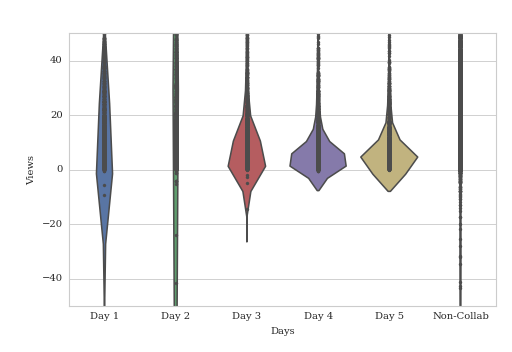

<IPython.core.display.Javascript object>


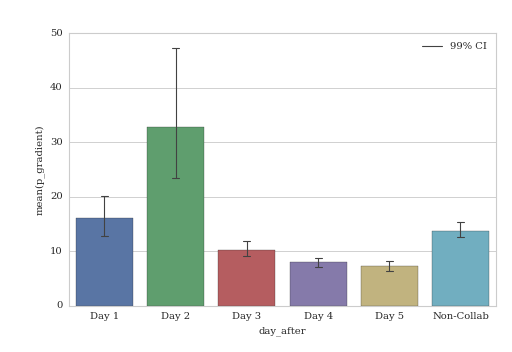

<IPython.core.display.Javascript object>


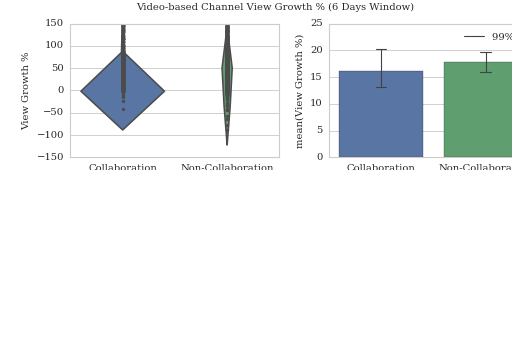

Non_Collabs:
count    32691.000000
mean        17.726679
std        130.534170
min        -89.448636
25%          2.225060
50%          4.265362
75%          9.485999
max       8388.888889
Name: p_gradient, dtype: float64

Collabs:
count    10660.000000
mean        16.066747
std        149.694755
min        -41.646873
25%          2.046031
50%          4.011295
75%          9.046038
max       8462.394958
Name: p_gradient, dtype: float64


<IPython.core.display.Javascript object>


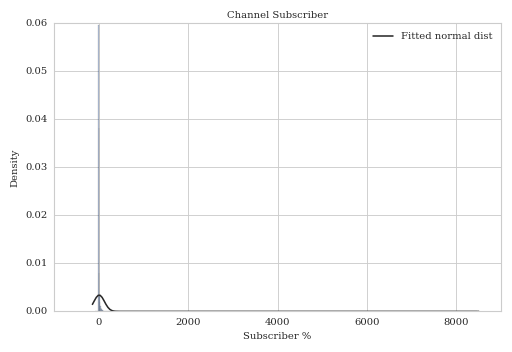

Normal-dist-test: NormaltestResult(statistic=174876.40943606119, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=167043365.5, pvalue=1.393431708491157e-10) 
p*2: 2.78686341698e-10
Wilcoxon rank-sum-test: RanksumsResult(statistic=-6.4166094700466143, pvalue=1.3934276322497475e-10) 
p*2: 2.7868552645e-10


In [135]:
fig = plt.figure()
ax = sns.violinplot(x=df_video_channel_viewcounts_collabs_days["day_after"], y=df_video_channel_viewcounts_collabs_days["p_gradient"],inner='point', order=[1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
ax.set_ylim([-50.0, 50.0])
save_plot('collab_channel_6days_video-based-views_box_perc_violin.pdf', fig, x_width, x_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_video_channel_viewcounts_collabs_days, ci=99, errwidth=1., capsize=.1, order=[1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
save_plot('collab_channel_6days_video-based-views_ci_perc.pdf', fig, x_width, x_height)

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs_days, ax=ax1,inner='point', order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs_days, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Growth %')
ax2.set_ylabel('mean(View Growth %)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Growth % (6 Days Window)')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-150.0, 150.0])
save_plot('collab_channel_6days_video-based-views_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Collab']['p_gradient'].describe()

test = df_video_channel_viewcounts_collabs_days
# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber %')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2